# Learn-Together: Random Forest

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


seed = 42

In [2]:
def generate_submission(model, test_data, test_ids, file_name):
    predictions = model.predict(test_data)
    output = pd.DataFrame({"Id": test_ids, "Cover_Type": predictions})
    output.to_csv("submissions/"+ file_name +".csv", index=False)

In [3]:
submission_ex = pd.read_csv("assets/learn-together/sample_submission.csv")
train_df = pd.read_csv("assets/learn-together/train.csv")
test_df = pd.read_csv("assets/learn-together/test.csv")

Given our earlier EDA, let's proceed to training a simple random forest model.

In [4]:
train_df.shape, test_df.shape

((15120, 56), (565892, 55))

In [5]:
target = ["Cover_Type"]
cols_to_drop = ["Id", "Soil_Type7", "Soil_Type15", "Cover_Type"]

train = train_df.copy()
test = test_df.copy()

y = train[target]
train.drop(columns=cols_to_drop, inplace=True)
test_ids = test["Id"]
test.drop(columns=["Id", "Soil_Type7", "Soil_Type15"], inplace=True)

In [6]:
train.shape, y.shape, test.shape

((15120, 52), (15120, 1), (565892, 52))

In [7]:
X_train, X_val, y_train, y_val = train_test_split(train,
                                                  y, 
                                                  test_size=0.2, 
                                                  random_state=seed)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((12096, 52), (12096, 1), (3024, 52), (3024, 1))

In [8]:
rf = RandomForestClassifier(n_estimators=100, 
                            random_state=seed)

rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [9]:
rf_predictions = rf.predict(X_val)
rf_accuracy = accuracy_score(y_val, rf_predictions)
rf_accuracy

0.8713624338624338

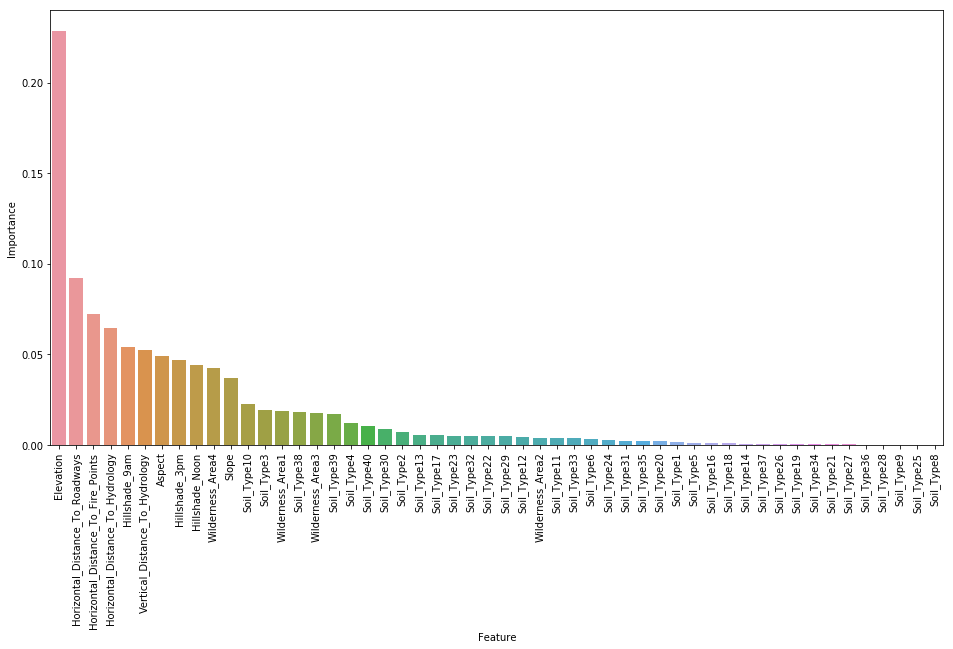

In [10]:
importances = rf.feature_importances_
rf_feature_importances = pd.DataFrame({"Importance": importances, "Feature": X_train.columns}).sort_values("Importance", ascending=False)

plt.figure(figsize=(16,8))
sns.barplot(x="Feature", y="Importance", data=rf_feature_importances)
plt.xticks(rotation="vertical")
plt.show()

In [11]:
# generate_submission(rf, test, test_ids, "random_forest_100")

#### Investigate Optimal Parameters with RandomSearchCV

* n_estimators: the number of trees in the forest
* max_depth: max number of nodes in each tree
* max_features: max number of features considered for splitting each node
* min_samples_split: min number of data points to be placed into node before it is split
* min_samples_leaf: min number of data points allowed in a leaf node
* boostrap: data sampling method (with or without replacement)

In [12]:
rf.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [16]:
n_estimators = [int(x) for x in np.linspace(start=100, stop=2000, num=10)]
max_features = ["auto", "sqrt"]
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [17]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator=rf, 
                               param_distributions=random_grid, 
                               n_iter=100, 
                               cv=3, 
                               verbose=2, 
                               random_state=seed, 
                               n_jobs=-1)

In [18]:
# This part takes a while...
# rf_random.fit(X_train, y_train.values.ravel())

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  9.7min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [19]:
rf_random.best_params_

{'n_estimators': 944,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 50,
 'bootstrap': False}

#### Optimal Parameters from RandomSearchCV:

```
params = {'n_estimators': 944,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 50,
 'bootstrap': False}
```

* Random params resulted in an accuracy of 85.76 vs 85.09 (improvement of 0.8%)

In [24]:
def evaluate_model(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print("Model Performance")
    print("Average Error: {:0.4f} degrees".format(np.mean(errors)))
    print("Accuracy: {:0.2f}".format(accuracy))
    
    return accuracy

In [27]:
base_model = RandomForestClassifier(n_estimators=100,
                                    random_state=seed)
base_model.fit(X_train, y_train.values.ravel())
base_accuracy = evaluate_model(base_model, X_val, y_val.values.ravel())

best_random = rf_random.best_estimator_
random_accuracy = evaluate_model(best_random, X_val, y_val.values.ravel())

print("Improvement of {:0.2f}%".format(100 * (random_accuracy - base_accuracy)/base_accuracy))

Model Performance
Average Error: 0.3032 degrees
Accuracy: 85.09
Model Performance
Average Error: 0.2923 degrees
Accuracy: 85.76
Improvement of 0.80%


#### GridSearch Over Fine Resolution Params

In [31]:
refined_param_grid = {
    'bootstrap': [False],
    'max_depth': [40, 50, 60, 70],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 4, 6],
    'n_estimators': [90, 100, 200, 300]    
}

In [32]:
rf = RandomForestClassifier()

rf_grid_search = GridSearchCV(estimator=rf, 
                              param_grid=refined_param_grid, 
                              cv=3, 
                              n_jobs=-1, 
                              verbose=2)

In [33]:
rf_grid_search.fit(X_train, y_train.values.ravel())

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   54.9s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  2.6min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'bootstrap': [False], 'max_depth': [40, 50, 60, 70], 'min_samples_leaf': [1, 2, 3], 'min_samples_split': [2, 4, 6], 'n_estimators': [90, 100, 200, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [34]:
rf_grid_search.best_params_

{'bootstrap': False,
 'max_depth': 50,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

In [36]:
best_grid = rf_grid_search.best_estimator_
best_grid_accuracy = evaluate_model(best_grid, X_val, y_val.values.ravel())

print("Improvement of {:0.2f}%".format(100 * (best_grid_accuracy - base_accuracy)/best_grid_accuracy))

Model Performance
Average Error: 0.2937 degrees
Accuracy: 85.82
Improvement of 0.85%


#### Optimal Parameters from RandomSearchCV:

```
best_params = {'bootstrap': False,
 'max_depth': 50,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}
```

* Best params resulted in an accuracy of 85.82 vs 85.09 (improvement of 0.85%)